In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import jax
import os

import jaxley as jx
import jaxley.optimize.transforms as jt
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

import optax
import time as time

import pandas as pd

### Multi-comp HH model setup

In [3]:
n_post_comp = 15
num_pre = 8
post_idx = num_pre # post cell index inside the network
Nsyn = num_pre

i_delay = 10.0    # ms
i_amp = 0.2   # nA
i_dur = 10.0   # ms
dt = 0.025  # ms
t_max = 50.0   # ms

base_amp = i_amp

syn_post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)

def build_net():
    comp_pre = jx.Compartment()
    branch_pre = jx.Branch(comp_pre, ncomp=1)
    cell_pre = jx.Cell(branch_pre, parents=np.asarray([-1]))

    comp_post = jx.Compartment()
    branch_post = jx.Branch(comp_post, ncomp=n_post_comp)
    cell_post = jx.Cell(branch_post, parents=np.asarray([-1]))

    pre_cells = [cell_pre for _ in range(num_pre)]
    cells = pre_cells + [cell_post]
    net = jx.Network(cells)

    net.insert(HH())

    syn = IonotropicSynapse()
    for pre_i, comp_i in zip(range(num_pre), syn_post_comp_indices):
        connect(
            net.cell(pre_i).branch(0).comp(0),
            net.cell(post_idx).branch(0).comp(int(comp_i)),
            syn,
        )
    return net

def setup_recordings(net, record_s: bool = True):
    net.delete_recordings()

    # 1) soma voltage
    net.cell(post_idx).branch(0).comp(0).record("v")

    # 2) synapse-compartment voltages (excluding soma if duplicated)
    syn_comps = [int(ci) for ci in syn_post_comp_indices if int(ci) != 0]
    for ci in syn_comps:
        net.cell(post_idx).branch(0).comp(ci).record("v")

    # 3) synapse state s (edge traces), optional
    if record_s:
        net.IonotropicSynapse.edge("all").record("IonotropicSynapse_s")

    return net


net_analysis = build_net()


net_analysis = setup_recordings(net_analysis)

# net_analysis.IonotropicSynapse.set("IonotropicSynapse_gS", 5e-4) # code to update if needed 
net_analysis.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
params_true = net_analysis.get_parameters()
print(f"Network: {net_analysis.nodes.shape[0]} compartments, "
      f"{net_analysis.edges.shape[0]} edges")
print(f"Number of synapses = {Nsyn}, syn_post_comp_indices = {syn_post_comp_indices}")




Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 8 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Network: 23 compartments, 8 edges
Number of synapses = 8, syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]


In [ ]:
print("node columns:", list(net_analysis.nodes.columns))

cols = [c for c in net_analysis.nodes.columns]

print("showing cols:", cols)
display(net_analysis.nodes[cols].head(15))

In [ ]:
print(net_analysis.edges.columns)

### Simulation Setup

In [4]:
t_warm = 40    
i_delay_eff = t_warm + i_delay #start
t_max_eff = t_warm + t_max #end
T_keep = int(round(t_max/dt)) + 1
i0 = int(round(t_warm/dt))
print(f"Warmup: t_warm={t_warm} ms, i0={i0}, T_keep={T_keep}, "
      f"total sim = {t_max_eff} ms")

def simulate_analysis(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay_eff, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max_eff,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(net_analysis, params=params_phys,
                          data_stimuli=data_stimuli, delta_t=dt)

    # crop out warmup toreturn clean 0 to 50ms window
    return traces[:, i0:i0 + T_keep]

def simulate_soma(params_phys, pattern):
    return simulate_analysis(params_phys, pattern)[0]   # (T,)

batched_simulate_soma = vmap(simulate_soma, in_axes=(None, 0)) # get many traces at once 

def loss_and_traces(params_phys, pattern, target):
    raw_traces = simulate_analysis(params_phys, pattern)
    soma_pred = raw_traces[0]
    loss = jnp.mean((soma_pred - target) ** 2)
    return loss, raw_traces

_vg_fn = jit(value_and_grad(loss_and_traces, argnums=0, has_aux=True))

def single_trial(params_phys, pattern, target):
    (loss, raw_traces), grads = _vg_fn(params_phys, pattern, target)
    grad_w = grads[0]["IonotropicSynapse_gS"]       # (Nsyn,)
    return grad_w, raw_traces, loss

# batched over patterns (shared params)
batched_vg = jit(jax.vmap(
    jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True),
    in_axes=(None, 0, 0),
))



Warmup: t_warm=40 ms, i0=1600, T_keep=2001, total sim = 90.0 ms


In [ ]:
print(f"Params_true = {params_true}")

In [5]:
gS_true = params_true[0]["IonotropicSynapse_gS"]
params_true = [{"IonotropicSynapse_gS": gS_true}]
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])

opt_params_true = transform.inverse(params_true)
key_learn = jax.random.PRNGKey(1)
sigma = 0.05  # 5% lognormal perturbation
gS_learned = jnp.clip(
    gS_true * jnp.exp(sigma * jax.random.normal(key_learn, (Nsyn,))),
    1e-5, 1e-2
)
params_analysis = [{"IonotropicSynapse_gS": gS_learned}]
gS_learned = params_analysis[0]["IonotropicSynapse_gS"]

print("gS_true:", gS_true)
print("gS_learned:", gS_learned)
print(f"max |diff|: {float(jnp.max(jnp.abs(gS_true - gS_learned))):.2e}")



gS_true: [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
gS_learned: [9.42504843e-05 9.94208316e-05 1.00867190e-04 1.04902940e-04
 9.59207643e-05 1.03514370e-04 1.00377964e-04 9.62495051e-05]
max |diff|: 5.75e-06


#### Pattern Visualization

In [6]:
patterns_zero = jnp.zeros(Nsyn,dtype=jnp.float64) # (8, 8)
print(f"\npatterns zero shape: {patterns_zero.shape}")
print(patterns_zero)

targets_zero = batched_simulate_soma(params_true, patterns_zero[None, :]) 
T = targets_zero.shape[1]                                   
t_arr = np.arange(T_keep) * dt

print(f"\ntargets_zero shape: {targets_zero.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")



patterns zero shape: (8,)
[0. 0. 0. 0. 0. 0. 0. 0.]



targets_zero shape: (1, 2001)
T = 2001,  dt = 0.025 ms,  t_max = 50.0 ms


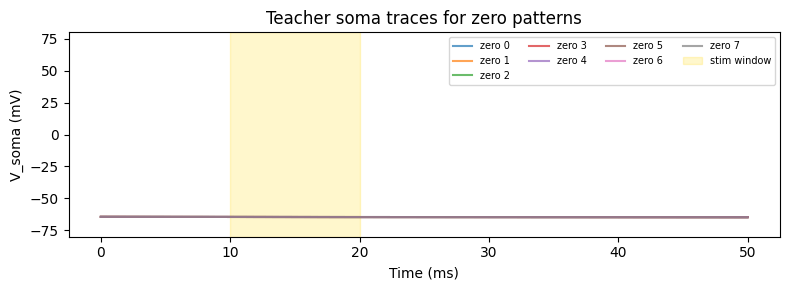

In [7]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_zero[p], alpha=0.7, label=f"zero {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_ylim(-80, 80)
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for zero patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

In [8]:
patterns_onehot = jnp.eye(Nsyn, dtype=jnp.float64)   # (8, 8)
print(f"\npatterns_onehot shape: {patterns_onehot.shape}")
print(patterns_onehot)

targets_onehot = batched_simulate_soma(params_true, patterns_onehot)   # (8, T)
T = targets_onehot.shape[1]                                            # time axis
t_arr = np.arange(T_keep) * dt

print(f"\ntargets_onehot shape: {targets_onehot.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")

print("\n── Gradients (student params vs teacher targets) ──")
for p in range(Nsyn):
    grad_w, raw_traces, loss = single_trial(params_analysis, patterns_onehot[p], targets_onehot[p])
    vmax_err = float(jnp.max(jnp.abs(raw_traces[0] - targets_onehot[p])))
    print(f"pattern {p}: loss={float(loss):.3e}  max|v-target|={vmax_err:.3e}  grad={grad_w}")


patterns_onehot shape: (8, 8)
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

targets_onehot shape: (8, 2001)
T = 2001,  dt = 0.025 ms,  t_max = 50.0 ms

── Gradients (student params vs teacher targets) ──
pattern 0: loss=7.718e-03  max|v-target|=2.375e-01  grad=[-2.69184291e+03 -1.07301620e+02 -5.21085721e+01 -2.55214582e+01
 -1.26293885e+01 -6.41332089e+00 -3.55899648e+00 -2.55471775e+00]
pattern 1: loss=1.696e-04  max|v-target|=2.438e-02  grad=[ -44.10251022 -191.47243512   -9.85663855   -4.78027774   -2.33160813
   -1.15590997   -0.61774702   -0.42877813]
pattern 2: loss=6.556e-05  max|v-target|=1.287e-02  grad=[-27.12856798 -12.93240105 -25.3945251   -2.92015668  -1.40168958
  -0.67804507  -0.34864315  -0.23338191]
pattern 3: loss=1.208e-04  max|v-target|=3.317e-02  grad=[-11.86792118  -5.77765455  -2.83841327  3

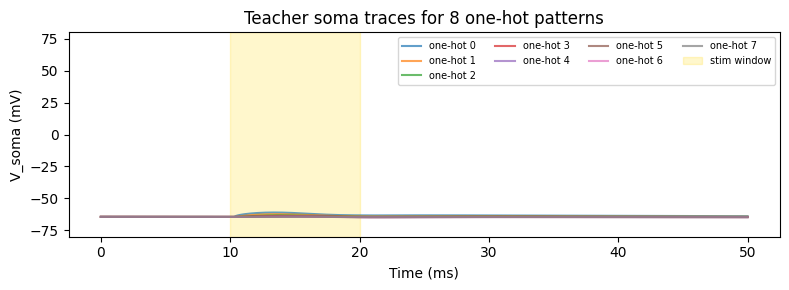

In [9]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_ylim(-80, 80)
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

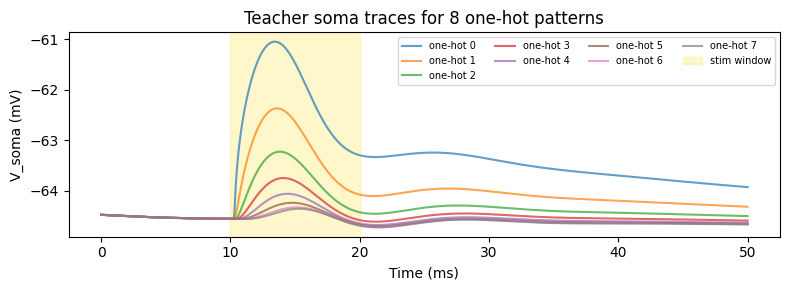

In [10]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

### Extract candidate correlates

In [14]:
def simulate_traces(params_phys, pattern, record_s: bool = True):
    traces = simulate_analysis(params_phys, pattern)  # (n_rec, T)

    # voltages we recorded: soma + (Nsyn-1) syn-comp voltages
    n_v = Nsyn  # soma + 7 others
    v_rec = traces[:n_v, :]  # (Nsyn, T) but in "record order"

    # Map recorded voltages back to "synapse index order"
    # We want Vsyn_by_i shape (Nsyn, T) where row i is voltage at synapse i's compartment.
    # synapse 0 is soma comp 0, which is v_rec[0].
    # For i>0, the recorded order matches syn_post_comp_indices excluding 0.
    Vsyn_by_i = []
    Vsyn_by_i.append(v_rec[0])  # synapse 0 at soma
    # the remaining recorded voltages correspond to synapse indices with comp != 0, in the same zip order
    v_ptr = 1
    for i, ci in enumerate(syn_post_comp_indices):
        if int(ci) == 0:
            continue
        Vsyn_by_i.append(v_rec[v_ptr])
        v_ptr += 1
    Vsyn_by_i = jnp.stack(Vsyn_by_i, axis=0)  # (Nsyn, T)

    if record_s:
        s_syn = traces[n_v:n_v + Nsyn, :]  # (Nsyn, T) in edge order
        return Vsyn_by_i, s_syn
    else:
        return Vsyn_by_i, None

In [15]:
def loss_only(params_phys, pattern, target):
    Vsyn, _ = simulate_traces(params_phys, pattern, record_s=False)
    v_soma = Vsyn[0]
    return jnp.mean((v_soma - target) ** 2)

loss_only_jit = jit(loss_only)
batched_vg_loss = jit(vmap(value_and_grad(loss_only, argnums=0), in_axes=(None, 0, 0)))

In [16]:
def _rising_edges(mask: jnp.ndarray) -> jnp.ndarray:
    """Boolean array marking rising edges of a boolean mask."""
    # mask: (T,)
    return jnp.logical_and(mask[1:], jnp.logical_not(mask[:-1]))  # (T-1,)

def _first_true_idx(mask: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Return (idx, has_any) where idx is first True index, -1 if none."""
    has = jnp.any(mask)
    idx = jnp.argmax(mask)                # 0 if none, so guard with has
    idx = jnp.where(has, idx, -1)
    return idx, has

def detect_spike_like_event(
    v: jnp.ndarray,
    dt: float,
    v_th: float,
    dvdt_th: float,
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Detects a spike-like event in a single trace v(t).
    Event happens if:
      - v crosses upward over v_th  OR
      - dV/dt crosses upward over dvdt_th

    Returns:
      has_event: bool
      first_idx: int (sample index in v), -1 if none
      n_events:  int (count of detected events; rough)
    """
    # 1) Voltage threshold crossing (upcrossings)
    above_v = v >= v_th
    v_cross = _rising_edges(above_v)            # (T-1,)
    v_first, has_v = _first_true_idx(v_cross)   # index into v_cross
    v_first = jnp.where(has_v, v_first + 1, -1) # map to v index
    n_v = jnp.sum(v_cross).astype(jnp.int32)

    # 2) dV/dt threshold crossing (fast upstroke)
    dvdt = jnp.diff(v) / dt                     # (T-1,) in mV/ms if v in mV and dt in ms
    above_d = dvdt >= dvdt_th
    d_cross = _rising_edges(above_d)            # (T-2,)
    d_first, has_d = _first_true_idx(d_cross)   # index into d_cross
    d_first = jnp.where(has_d, d_first + 2, -1) # +2 to map to v index
    n_d = jnp.sum(d_cross).astype(jnp.int32)

    has_event = jnp.logical_or(has_v, has_d)

    big = jnp.int32(v.shape[0] + 1)
    v_idx = jnp.where(has_v, v_first.astype(jnp.int32), big)
    d_idx = jnp.where(has_d, d_first.astype(jnp.int32), big)
    first_idx = jnp.minimum(v_idx, d_idx)
    first_idx = jnp.where(has_event, first_idx, -1)

    n_events = (n_v + n_d).astype(jnp.int32)
    return has_event, first_idx.astype(jnp.int32), n_events

# JIT + VMAP helpers
detect_spike_like_event_jit = jit(detect_spike_like_event)

# Batch over compartments: traces shape (C, T)
batched_detect = jit(vmap(detect_spike_like_event, in_axes=(0, None, None, None)))

def analyze_trial_events(
    raw_traces: jnp.ndarray,  # (n_recordings, T)
    dt: float,
    soma_v_th: float = 0.0,
    soma_dvdt_th: float = 30.0,
    dend_v_th: float = -20.0,
    dend_dvdt_th: float = 10.0,
):
    soma_v = raw_traces[0]
    dend_v = raw_traces[1:]  # (n_dend, T)

    # Somatic AP
    soma_has, soma_t0, soma_n = detect_spike_like_event_jit(
        soma_v, dt, soma_v_th, soma_dvdt_th
    )

    # Dendritic spike-like events (per recorded dend trace)
    dend_has, dend_t0, dend_n = batched_detect(
        dend_v, dt, dend_v_th, dend_dvdt_th
    )  # each: (n_dend,)

    dend_any = jnp.any(dend_has)

    # If soma spikes, check whether any dendritic event occurs BEFORE soma event
    # (simple heuristic for dendritic-led vs bAP-driven events)
    soma_t0_safe = jnp.where(soma_has, soma_t0, jnp.int32(raw_traces.shape[1] + 1))
    dend_leads_soma = jnp.logical_and(dend_has, dend_t0 < soma_t0_safe)  # (n_dend,)
    any_dend_leads = jnp.any(dend_leads_soma)

    # Dend spikes without soma spike:
    dend_without_soma = jnp.logical_and(dend_any, jnp.logical_not(soma_has))

    return {
        "soma_has_ap": soma_has,
        "soma_t0_idx": soma_t0,
        "dend_any": dend_any,
        "dend_has": dend_has,
        "dend_t0_idx": dend_t0,
        "any_dend_leads_soma": any_dend_leads,
        "dend_without_soma": dend_without_soma,
    }

# one pattern
raw_traces = simulate_analysis(params_true, patterns_onehot[0])  # (n_recordings, T_keep)
stats = analyze_trial_events(raw_traces, dt)
print(stats["soma_has_ap"], stats["dend_without_soma"], stats["any_dend_leads_soma"])

False True True


In [17]:
def extract_features(
    Vsyn,           # (Nsyn, T) voltage at synapse compartments (aligned by synapse index)
    s_syn,           # (Nsyn, T) or None
    params_phys,     # to get gS
    dt: float,
    i_delay_ms: float,
    i_dur_ms: float,
    baseline_ms: float = 5.0,
    post_ms: float = 10.0,
    bap_window_ms: float = 8.0,
    soma_v_th: float = 0.0,
    soma_dvdt_th: float = 30.0,
    dend_v_th: float = -20.0,
    dend_dvdt_th: float = 10.0,
):
    T = Vsyn.shape[1]
    def ms_to_idx(x): return int(round(x / dt))

    t_on  = ms_to_idx(i_delay_ms)
    t_end = min(T, ms_to_idx(i_delay_ms + i_dur_ms + post_ms))
    t0_base = max(0, t_on - ms_to_idx(baseline_ms))
    t1_base = t_on

    # soma event
    soma_v = Vsyn[0]
    soma_has, soma_t0, _ = detect_spike_like_event_jit(soma_v, dt, soma_v_th, soma_dvdt_th)

    # presyn-locked voltage window
    Vb = Vsyn[:, t0_base:t1_base]
    Va = Vsyn[:, t_on:t_end]
    base = jnp.mean(Vb, axis=1)
    dep  = jnp.maximum(Va - base[:, None], 0.0)

    depol_peak = jnp.max(Va, axis=1) - base
    depol_int  = jnp.sum(dep, axis=1) * dt
    dvdt_max   = jnp.max(jnp.diff(Va, axis=1) / dt, axis=1)

    # local dend spike-like event per synapse compartment
    syn_has, syn_t0, _ = batched_detect(Vsyn, dt, dend_v_th, dend_dvdt_th)

    # bAP amplitude after soma spike
    bapW = ms_to_idx(bap_window_ms)
    t0 = jnp.clip(soma_t0, 0, T)
    t1 = jnp.clip(soma_t0 + bapW, 0, T)

    def bap_amp_one(v):
        seg = v[t0:t1]
        vpre = v[jnp.maximum(t0 - 1, 0)]
        return jnp.where(soma_has, jnp.max(seg) - vpre, 0.0)

    bap_amp = vmap(bap_amp_one)(Vsyn)

    # eligibility features if s is available
    if s_syn is None:
        s_int = jnp.zeros((Nsyn,), dtype=jnp.float32)
        sv_int = jnp.zeros((Nsyn,), dtype=jnp.float32)
        I_abs_int = jnp.zeros((Nsyn,), dtype=jnp.float32)
    else:
        sa = s_syn[:, t_on:t_end]
        s_int = jnp.sum(sa, axis=1) * dt
        sv_int = jnp.sum(sa * dep, axis=1) * dt

        gS = params_phys[0]["IonotropicSynapse_gS"]
        # e_syn is 0 for you, so current proxy is gS*s*V
        I_syn = gS[:, None] * sa * Va
        I_abs_int = jnp.sum(jnp.abs(I_syn), axis=1) * dt

    feats = jnp.stack([
        depol_peak,
        depol_int,
        dvdt_max,
        syn_has.astype(jnp.float32),
        syn_t0.astype(jnp.float32),     # -1 if none
        bap_amp,
        s_int,
        sv_int,
        I_abs_int,
        soma_has.astype(jnp.float32) * jnp.ones((Nsyn,)),  # control baseline
    ], axis=1)

    return feats, soma_has, soma_t0

In [18]:
def one_hot_patterns(num_pre):
    return jnp.eye(num_pre, dtype=jnp.float32)

def make_check_patterns(num_pre, K, key):
    z = jnp.zeros((1, num_pre), dtype=jnp.float32)
    o = jnp.ones((1, num_pre), dtype=jnp.float32)
    oh = one_hot_patterns(num_pre)  # (num_pre, num_pre)

    base = jnp.concatenate([z, o, oh], axis=0)  # (2+num_pre, num_pre)

    # fill remaining slots with random Bernoulli patterns
    remaining = max(0, K - base.shape[0])
    if remaining > 0:
        rnd = jax.random.bernoulli(key, p=0.5, shape=(remaining, num_pre)).astype(jnp.float32)
        pats = jnp.concatenate([base, rnd], axis=0)
    else:
        pats = base[:K]
    return pats


In [19]:
# 1) patterns + targets (teacher)
K = 64
key = jax.random.PRNGKey(0)
patterns = make_check_patterns(num_pre=8, K=K, key=key)
targets = batched_simulate_soma(params_true, patterns)  # (K, T)

# 2) gradients (batched, fast)
losses, grads = batched_vg_loss(params_analysis, patterns, targets)
gS_grads = grads[0]["IonotropicSynapse_gS"]  # (K, Nsyn)

# 3) features (loop over K; you can vmap later once it's stable)
# 3) features (loop over K; you can vmap later once it's stable)
X_list = []
soma_flags = []
soma_t0s = []

for k in range(K):
    Vsyn, s_syn = simulate_traces(params_analysis, patterns[k], record_s=True)
    feats, soma_has, soma_t0 = extract_features(Vsyn, s_syn, params_analysis, dt, i_delay, i_dur)

    X_list.append(feats)              # (Nsyn, F)
    soma_flags.append(soma_has)       # scalar bool
    soma_t0s.append(soma_t0)          # scalar int

X = jnp.stack(X_list, axis=0)         # (K, Nsyn, F)
soma_flags = jnp.array(soma_flags)    # (K,) bool
soma_t0s = jnp.array(soma_t0s)        # (K,) int
Y = gS_grads                           # (K, Nsyn)


In [20]:
print("Total K:", K)
print("Soma spikes:", int(jnp.sum(soma_flags)), "Non-spikes:", int(jnp.sum(~soma_flags)))

for i in range(Nsyn):
    on = patterns[:, i] == 1.0
    print(f"syn{i} on:", int(jnp.sum(on)),
          "on&spike:", int(jnp.sum(on & soma_flags)),
          "on&nospike:", int(jnp.sum(on & ~soma_flags)))

Total K: 64
Soma spikes: 38 Non-spikes: 26
syn0 on: 31 on&spike: 22 on&nospike: 9
syn1 on: 27 on&spike: 24 on&nospike: 3
syn2 on: 26 on&spike: 20 on&nospike: 6
syn3 on: 33 on&spike: 25 on&nospike: 8
syn4 on: 34 on&spike: 25 on&nospike: 9
syn5 on: 27 on&spike: 23 on&nospike: 4
syn6 on: 27 on&spike: 22 on&nospike: 5
syn7 on: 28 on&spike: 22 on&nospike: 6


In [21]:

def corr_pearson(x, y, eps=1e-12):
    x = x - jnp.mean(x)
    y = y - jnp.mean(y)
    return jnp.sum(x*y) / (jnp.sqrt(jnp.sum(x*x) + eps) * jnp.sqrt(jnp.sum(y*y) + eps))

# X: (K, Nsyn, F), Y: (K, Nsyn)
K, Nsyn, F = X.shape

corr_mat = jnp.zeros((Nsyn, F))
for i in range(Nsyn):
    for f in range(F):
        corr_mat = corr_mat.at[i, f].set(corr_pearson(X[:, i, f], Y[:, i]))

corr_mat  # (Nsyn, F): correlation of each feature with gradient for each synapse

Array([[-0.14033977, -0.17140558, -0.06945338, -0.15928189, -0.16089866,
        -0.11299185, -0.19965459, -0.26785113, -0.190557  , -0.15928189],
       [-0.06302618, -0.0792195 , -0.03464147, -0.07376771, -0.07108239,
        -0.07921931, -0.10351127, -0.11753256, -0.10016734, -0.07376771],
       [-0.1975975 , -0.20941905, -0.18425342, -0.20460975, -0.21925669,
        -0.2425471 , -0.29592328, -0.35339415, -0.29013308, -0.20460975],
       [ 0.15148597,  0.17545777,  0.12852854,  0.16385407,  0.2152843 ,
        -0.06026562,  0.19447731,  0.2418624 ,  0.1872266 ,  0.16385407],
       [-0.07541466, -0.06430317, -0.05744545, -0.07277434, -0.06555674,
         0.09933265, -0.08522866, -0.10318035, -0.08662544, -0.07277434],
       [ 0.08592353,  0.1048533 ,  0.08061909,  0.09521296,  0.12103656,
        -0.09247257,  0.13541382,  0.15409417,  0.13094681,  0.09521296],
       [ 0.09910596,  0.11545637,  0.09412987,  0.10764024,  0.13817178,
        -0.09944892,  0.15319107,  0.175299  

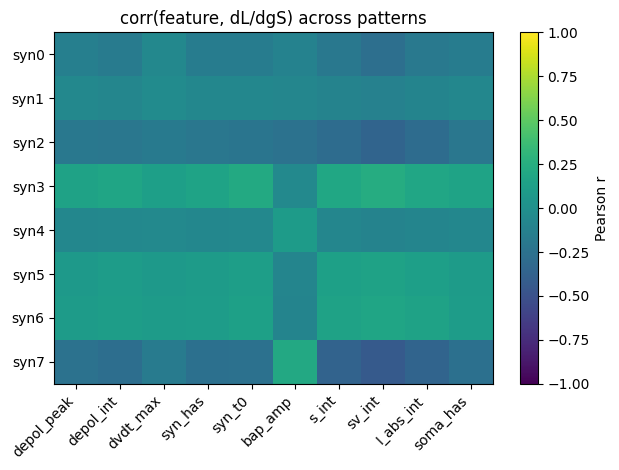

In [22]:
feature_names = [
    "depol_peak","depol_int","dvdt_max","syn_has","syn_t0",
    "bap_amp","s_int","sv_int","I_abs_int","soma_has"
]

C = np.array(corr_mat)  # your 8x10 matrix

plt.figure()
plt.imshow(C, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.yticks(range(Nsyn), [f"syn{i}" for i in range(Nsyn)])
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.title("corr(feature, dL/dgS) across patterns")
plt.tight_layout()
plt.show()

In [23]:
def corr_mat_conditioned_on_syn_on(X, Y, patterns):
    K, Nsyn, F = X.shape
    C = jnp.zeros((Nsyn, F))
    for i in range(Nsyn):
        mask = patterns[:, i] == 1.0
        for f in range(F):
            C = C.at[i, f].set(corr_pearson(X[mask, i, f], Y[mask, i]))
    return C

C_on = corr_mat_conditioned_on_syn_on(X, Y, patterns)

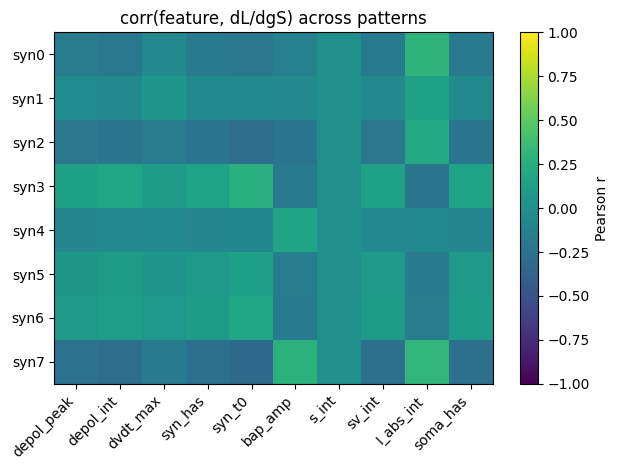

In [25]:

C = np.array(C_on)  # your 8x10 matrix

plt.figure()
plt.imshow(C, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.yticks(range(Nsyn), [f"syn{i}" for i in range(Nsyn)])
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.title("corr(feature, dL/dgS) across patterns")
plt.tight_layout()
plt.show()

In [24]:
# make sure you stored soma_flags per trial when building X
# soma_flags shape: (K,) boolean

def corr_mat_on_and_spike(X, Y, patterns, soma_flags, spike_val: bool):
    K, Nsyn, F = X.shape
    C = jnp.zeros((Nsyn, F))
    for i in range(Nsyn):
        mask = (patterns[:, i] == 1.0) & (soma_flags == spike_val)
        for f in range(F):
            # guard for too-few samples
            C = C.at[i, f].set(jnp.where(jnp.sum(mask) >= 5,
                                         corr_pearson(X[mask, i, f], Y[mask, i]),
                                         jnp.nan))
    return C

C_on_spike    = corr_mat_on_and_spike(X, Y, patterns, soma_flags, True)
C_on_nospike  = corr_mat_on_and_spike(X, Y, patterns, soma_flags, False)

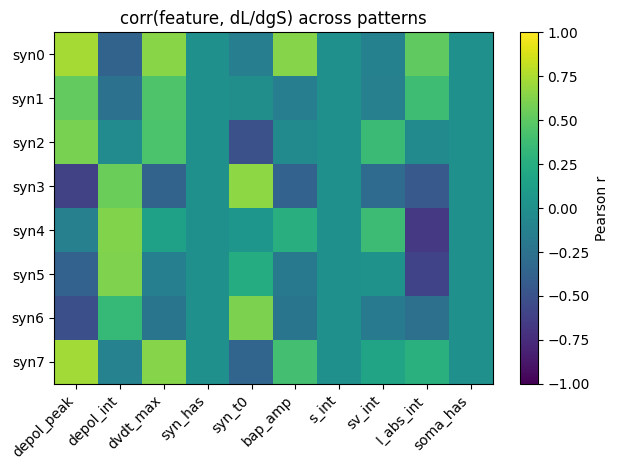

In [26]:

C = np.array(C_on_spike)  # your 8x10 matrix

plt.figure()
plt.imshow(C, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.yticks(range(Nsyn), [f"syn{i}" for i in range(Nsyn)])
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.title("corr(feature, dL/dgS) across patterns")
plt.tight_layout()
plt.show()

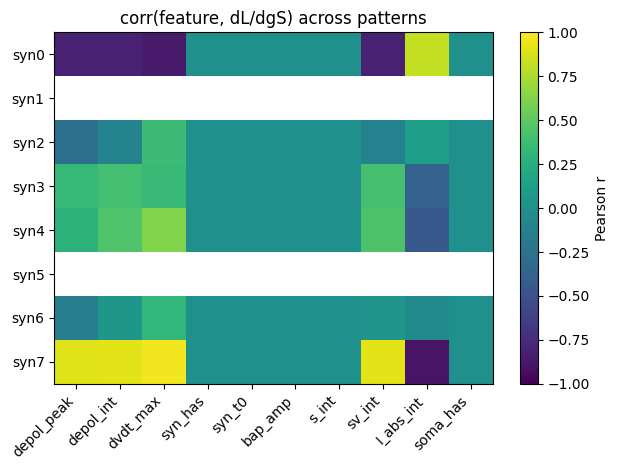

In [27]:

C = np.array(C_on_nospike)  # your 8x10 matrix

plt.figure()
plt.imshow(C, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.yticks(range(Nsyn), [f"syn{i}" for i in range(Nsyn)])
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")
plt.title("corr(feature, dL/dgS) across patterns")
plt.tight_layout()
plt.show()

In [28]:
mask_spike = soma_flags == True
X_sp = X[mask_spike]   # (K_sp, Nsyn, F)
Y_sp = Y[mask_spike]   # (K_sp, Nsyn)
P_sp = patterns[mask_spike]
print("K_spike:", X_sp.shape[0])

F_SYN_HAS = 3
F_SYN_T0  = 4

def corr_pearson_masked(x, y, mask, eps=1e-12):
    x = x[mask]; y = y[mask]
    return jnp.where(x.shape[0] >= 5, corr_pearson(x, y, eps=eps), jnp.nan)

def corr_mat_spike_on(Xs, Ys, Ps):
    Ksp, Nsyn, F = Xs.shape
    C = jnp.zeros((Nsyn, F))
    for i in range(Nsyn):
        syn_on = Ps[:, i] == 1.0
        for f in range(F):
            if f == F_SYN_T0:
                valid = syn_on & (Xs[:, i, F_SYN_HAS] > 0.5)
                C = C.at[i,f].set(corr_pearson_masked(Xs[:, i, f], Ys[:, i], valid))
            else:
                C = C.at[i,f].set(corr_pearson_masked(Xs[:, i, f], Ys[:, i], syn_on))
    return C

C_spike_on = corr_mat_spike_on(X_sp, Y_sp, P_sp)

K_spike: 38


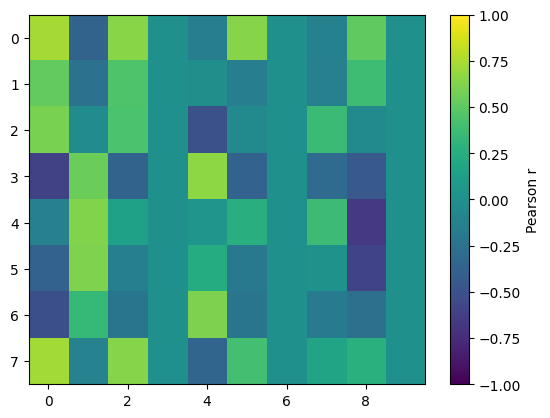

In [29]:
C = np.array(C_spike_on)  # your 8x10 matrix

plt.figure()
plt.imshow(C, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")


### Optional hyperparameter tuning: minimal synaptic weight and pattern to create somatic action potential

In [ ]:
def has_somatic_ap(v_soma: jnp.ndarray, dt: float,
                   v_overshoot_th: float = 0.0,
                   dvdt_th: float = 30.0,
                   v_floor_for_dvdt: float = -20.0) -> jnp.bool_:
    # condition A: overshoot
    overshoot = jnp.any(v_soma >= v_overshoot_th)

    # condition B: fast upstroke + sufficiently depolarized
    dvdt = jnp.diff(v_soma) / dt  # mV/ms
    fast_up = jnp.any((dvdt >= dvdt_th) & (v_soma[1:] >= v_floor_for_dvdt))

    return overshoot | fast_up

batched_has_somatic_ap = jit(vmap(has_somatic_ap, in_axes=(0, None, None, None, None)))

In [ ]:
# pattern_all_on  = jnp.ones((Nsyn,), dtype=jnp.float32)

# def patterns_of_weight(k: int) -> jnp.ndarray:
#     from itertools import combinations
#     idxs = []
#     for comb in combinations(range(Nsyn), k):
#         p = np.zeros((Nsyn,), dtype=np.float32)
#         p[list(comb)] = 1.0
#         idxs.append(p)
#     return jnp.asarray(np.stack(idxs, axis=0))

# # identify which synapse is on soma (comp 0)
# soma_syn_mask = (syn_post_comp_indices == 0)
# # if multiple happen to be 0 (unlikely), this still works.
# soma_onehot_indices = np.where(soma_syn_mask)[0].tolist()

# def eval_gS(gS_value: float):
#     # set ALL synapses to this gS (same as you do)
#     net_analysis.IonotropicSynapse.set("IonotropicSynapse_gS", float(gS_value))

#     params = net_analysis.get_parameters()
#     gS_vec = params[0]["IonotropicSynapse_gS"]
#     params_phys = [{"IonotropicSynapse_gS": gS_vec}]

#     # all-on
#     v_all = simulate_soma(params_phys, pattern_all_on)
#     all_on_ap = bool(has_somatic_ap(v_all, dt))

#     # onehots
#     v_1 = batched_simulate_soma(params_phys, patterns_onehot)  # (8,T)
#     onehot_ap = batched_has_somatic_ap(v_1, dt, 0.0, 30.0, -20.0)  # (8,)
#     onehot_ap = jnp.asarray(onehot_ap)

#     n_onehot = int(jnp.sum(onehot_ap))
#     any_onehot = bool(jnp.any(onehot_ap))

#     # minimal k
#     min_k = None
#     for k in range(1, Nsyn + 1):
#         Pk = patterns_of_weight(k)
#         v_k = batched_simulate_soma(params_phys, Pk)
#         ap_k = batched_has_somatic_ap(v_k, dt, 0.0, 30.0, -20.0)
#         if bool(jnp.any(ap_k)):
#             min_k = k
#             break

#     return {
#         "gS": float(gS_value),
#         "all_on_ap": all_on_ap,
#         "onehot_ap": onehot_ap,   # boolean (8,)
#         "n_onehot_ap": n_onehot,
#         "min_k": min_k,
#     }

# # run sweep
# gS_sweep = np.geomspace(1e-4, 5e-4, 9)
# results = [eval_gS(g) for g in gS_sweep]

# for r in results:
#     print(f"gS={r['gS']:.2e} | all-on AP={r['all_on_ap']} | "
#           f"onehot AP={r['n_onehot_ap']}/8 | min_k={r['min_k']}")

# # pick rule A: strict (no onehot AP at all)
# picked_strict = None
# for r in results:
#     if r["all_on_ap"] and (r["n_onehot_ap"] == 0) and (r["min_k"] is not None) and (2 <= r["min_k"] <= 5):
#         picked_strict = r
#         break

# # pick rule B: allow soma-onehot AP only
# picked_allow_soma = None
# for r in results:
#     oh = np.array(r["onehot_ap"], dtype=bool)
#     ok = True
#     for i in range(Nsyn):
#         if oh[i] and (i not in soma_onehot_indices):  # any non-soma onehot AP -> reject
#             ok = False
#             break
#     if r["all_on_ap"] and ok and (r["min_k"] is not None) and (2 <= r["min_k"] <= 5):
#         picked_allow_soma = r
#         break

# print("\nPicked (strict):", None if picked_strict is None else picked_strict["gS"])
# print("Picked (allow soma onehot):", None if picked_allow_soma is None else picked_allow_soma["gS"])

In [ ]:
def patterns_of_weight_k(N, k, dtype=np.float64):
    pats = []
    from itertools import combinations
    for comb in combinations(range(N), k):
        p = np.zeros((N,), dtype=dtype)
        p[list(comb)] = 1.0
        pats.append(p)
    return jnp.asarray(np.stack(pats, axis=0))

patterns_3hot = patterns_of_weight_k(Nsyn, 3)   # (56, 8)
print("patterns_3hot shape:", patterns_3hot.shape)

# ---- simulate soma for all 3-hot patterns
targets_3hot = batched_simulate_soma(params_true, patterns_3hot)  # (56, T)
T = targets_3hot.shape[1]
t_arr = np.arange(T_keep) * dt

print("targets_3hot shape:", targets_3hot.shape)

# ---- (optional) compute which 3-hot patterns cause somatic AP (using your AP detector)
ap_3hot = jnp.array([has_somatic_ap(targets_3hot[i], dt) for i in range(targets_3hot.shape[0])])
print(f"# somatic APs in 3-hot set: {int(ap_3hot.sum())} / {targets_3hot.shape[0]}")

# ---- plot: overlay all traces (AP ones thicker)
fig, ax = plt.subplots(figsize=(9, 3.5))

for i in range(targets_3hot.shape[0]):
    if bool(ap_3hot[i]):
        ax.plot(t_arr, np.array(targets_3hot[i]), alpha=0.9, lw=1.5)
    else:
        ax.plot(t_arr, np.array(targets_3hot[i]), alpha=0.15, lw=1.0)

ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_ylim(-80, 80)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for all 56 three-hot patterns (thick = AP)")
plt.tight_layout()
plt.show()

# ---- (optional) show which 3-hot patterns spiked (by indices)
spiking_idx = np.where(np.array(ap_3hot, dtype=bool))[0]
print("Spiking 3-hot pattern indices:", spiking_idx)

# print the actual active synapse indices for each spiking pattern
for i in spiking_idx[:]:  # show first 10
    on = np.where(np.array(patterns_3hot[i]) > 0.5)[0]
    print(f"pattern {i}: on synapses {on}")

In [ ]:
# # syn_post_comp_indices tells you where synapse i lands
# spiking_patterns = spiking_idx 
# P = np.array(patterns_3hot)
# comp = np.array(syn_post_comp_indices)

# # average landing position for each 3-hot pattern
# avg_comp = (P @ comp) / 3.0

# print("mean avg_comp among all patterns:", avg_comp.mean())
# print("mean avg_comp among spiking patterns:", avg_comp[spiking_patterns].mean())

### Infrastructure to detect dendritic events (use in correlations)

In [ ]:
def detect_event_per_trace(v: jnp.ndarray, dt: float,
                           v_th: float = -20.0,
                           dvdt_th: float = 10.0) -> jnp.bool_:
    above_v = jnp.any(v >= v_th)
    dvdt = jnp.diff(v) / dt
    fast = jnp.any(dvdt >= dvdt_th)
    return above_v | fast

batched_detect_event = jit(vmap(detect_event_per_trace, in_axes=(0, None, None, None)))

def dendritic_events(raw_traces_post: jnp.ndarray, dt: float):
    # raw_traces_post: (n_post_comp, T), comp 0 is soma
    soma_v = raw_traces_post[0]
    dend_v = raw_traces_post[1:]

    soma_ap = has_somatic_ap(soma_v, dt)
    dend_evt = batched_detect_event(dend_v, dt, -20.0, 10.0)  # (n_post_comp-1,)
    dend_any = jnp.any(dend_evt)

    dend_without_soma = dend_any & (~soma_ap)
    return soma_ap, dend_evt, dend_without_soma

### Gradient Factorization

Because loss is:
```
L = mean_t (V_soma(t) - target(t))^2
```

the "credit/adjoint" term is analytic:

$$\frac{\partial L}{\partial V_{\text{soma}}(t)} = \frac{2}{T}\,(V_{\text{soma}}(t) - \text{target}(t))$$

We have:
1. autograd gradient `dL/dg` (what you already do)
2. Jacobian $J(t,i) = \partial V(t) / \partial g_i$
3. factorized gradient $J^\top \cdot (dL/dV)$
4. verify they match

In [ ]:
pattern = patterns_onehot[0]

# teacher target
target = batched_simulate_soma(params_true, pattern[None, :])[0]

# student params (perturbed)
gS_student = params_analysis[0]["IonotropicSynapse_gS"]

params_student = [{"IonotropicSynapse_gS": gS_student}]

grad_w, raw_traces, loss = single_trial(params_student, pattern, target)

v = raw_traces[0]
T = v.shape[0]
dL_dV = (2.0 / T) * (v - target)

def soma_from_gS(gS_vec, pattern):
    params_phys = [{"IonotropicSynapse_gS": gS_vec}]
    return simulate_soma(params_phys, pattern)   # (T_keep,)

# 2) Jacobian: dV_soma(t)/dgS_i
J_soma_wrt_gS = jit(jax.jacfwd(soma_from_gS, argnums=0))
# returns shape (T_keep, Nsyn)

J = J_soma_wrt_gS(gS_student, pattern)   # (T, Nsyn)
grad_fact = J.T @ dL_dV                  # (Nsyn,)

max_abs = jnp.max(jnp.abs(grad_w - grad_fact))
rel = max_abs / (jnp.max(jnp.abs(grad_w)) + 1e-12)

print("loss:", float(loss))
print("grad_w:", grad_w)
print("grad_fact:", grad_fact)
print("max |diff|:", float(max_abs))
print("rel:", float(rel))

In [ ]:
J_soma_wrt_gS = jit(jax.jacfwd(soma_from_gS, argnums=0))  # (T, Nsyn)

# batch over patterns: returns (P, T, Nsyn)
batched_J = jit(jax.vmap(lambda pat, gS: J_soma_wrt_gS(gS, pat),
                         in_axes=(0, None)))

Analysis

In [ ]:
# def make_batched_vg_for_net(net_obj):
#     def simulate_analysis_net(params_phys, pattern):
#         amps = base_amp * pattern
#         currents = jx.datapoint_to_step_currents(
#             i_delay=i_delay_eff, i_dur=i_dur,
#             i_amp=amps, delta_t=dt, t_max=t_max_eff,
#         )
#         net_obj.delete_stimuli()
#         data_stimuli = None
#         for i in range(num_pre):
#             data_stimuli = (
#                 net_obj.cell(i).branch(0).loc(0.0)
#                 .data_stimulate(currents[i], data_stimuli=data_stimuli)
#             )
#         traces = jx.integrate(net_obj, params=params_phys,
#                               data_stimuli=data_stimuli, delta_t=dt)
#         return traces[:, i0:i0 + T_keep]   # (n_sites, T_keep)

#     def loss_and_traces_net(params_phys, pattern, target):
#         raw_traces = simulate_analysis_net(params_phys, pattern)
#         soma_pred = raw_traces[0]
#         loss = jnp.mean((soma_pred - target) ** 2)
#         return loss, raw_traces

#     batched_vg_net = jit(jax.vmap(
#         jax.value_and_grad(loss_and_traces_net, argnums=0, has_aux=True),
#         in_axes=(None, 0, 0),
#     ))
#     return simulate_analysis_net, batched_vg_net

In [ ]:
# probe patterns
patterns_probe = patterns_3hot            # (56, 8)
P = patterns_probe.shape[0]

# teacher targets for those probes
batched_simulate_soma_probe = jit(vmap(simulate_soma, in_axes=(None, 0)))
targets_probe = batched_simulate_soma_probe(params_true, patterns_probe)  # (56, T_keep)

In [ ]:
net_train = build_net()
net_train.delete_recordings()
net_train.cell(post_idx).branch(0).comp(0).record() # soma only
for ci in syn_post_comp_indices:
    if int(ci) != 0:
        net_train.cell(post_idx).branch(0).comp(int(ci)).record() # all synapses except soma
net_train.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

train_transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])

def _sim_soma_train(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay_eff, i_dur=i_dur, i_amp=amps, delta_t=dt, t_max=t_max_eff,
    )
    net_train.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_train.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_train, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    # crop out warmup to return clean 0...50ms window
    return traces[0, i0:i0 + T_keep] # (T,)

_batched_soma_train = vmap(_sim_soma_train, in_axes=(None, 0))

def _train_loss_batch(opt_params, pats, tgts):
    params_phys = train_transform.forward(opt_params)
    preds = _batched_soma_train(params_phys, pats)            # (B, T)
    return jnp.mean((preds - tgts) ** 2)

train_lr = 0.05
train_optimizer = optax.adam(train_lr)

@jit
def _train_step(opt_params, opt_state, pats, tgts):
    loss, grads = jax.value_and_grad(_train_loss_batch)(
        opt_params, pats, tgts,
    )
    updates, new_state = train_optimizer.update(grads, opt_state, opt_params)
    new_params = optax.apply_updates(opt_params, updates)
    return new_params, new_state, loss

checkpoints = [10, 25, 50]
n_steps_train = max(checkpoints)  

def train_one_seed(seed, patterns_train, targets_train,
                   n_steps=50, checkpoints=(10, 25, 50), log_every=5):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    gS0 = jnp.clip(
        1e-4 * jnp.exp(0.15 * jax.random.normal(subkey, (Nsyn,))),
        1e-5, 1e-2,
    )
    params0 = [{"IonotropicSynapse_gS": gS0}]
    opt_params = train_transform.inverse(params0)
    opt_state = train_optimizer.init(opt_params)

    loss_log = []
    checkpoint_params = {}   
    ckpt_set = set(checkpoints)

    for step in range(1, n_steps + 1):
        opt_params, opt_state, loss = _train_step(
            opt_params, opt_state, patterns_train, targets_train,
        )

        if step % log_every == 0 or step == n_steps:
            loss_log.append((step, float(loss)))

        if step in ckpt_set:
            checkpoint_params[step] = train_transform.forward(opt_params)

    return checkpoint_params, {"losses": loss_log, "final_loss": float(loss)}


print(f"Sanity check: training seed=0 ({n_steps_train} steps, "
      f"checkpoints at {checkpoints})")
t0 = time.time()
ckpt0, log0 = train_one_seed(0, patterns_probe, targets_probe)
t1 = time.time()
print(f"Time: {t1-t0:.1f}s")
print(f"Init loss: {log0['losses'][0][1]:.4f}")
print(f"Final loss:{log0['final_loss']:.4f}")
for c in sorted(ckpt0):
    gS_c = np.asarray(ckpt0[c][0]["IonotropicSynapse_gS"])
    print(f"gS @ step {c:3d}: {gS_c}  "
          f"(max |diff| from true = {np.abs(gS_c - np.asarray(gS_true)).max():.2e})")


In [ ]:
# 1) Edges: do they match exactly (pre/post + post_comp location)?
cols = ["pre_index", "post_index", "post_locs", "type", "type_ind", "IonotropicSynapse_gS"]
print(net_analysis.edges[cols].reset_index(drop=True).head(10))
print(net_train.edges[cols].reset_index(drop=True).head(10))

same_edges = net_analysis.edges[cols].reset_index(drop=True).equals(
    net_train.edges[cols].reset_index(drop=True)
)
print("same edge table:", same_edges)

# 2) Recordings: do they match?
print("analysis recordings:", net_analysis.recordings)
print("train recordings:", net_train.recordings)
print("same recordings:", net_analysis.recordings == net_train.recordings)

In [ ]:
S = 30

n_sites = 1 + np.sum(np.array(syn_post_comp_indices) != 0)  # soma + nonzero syn comps
# with your setup, n_sites should be 8

VALL_ckpt  = {c: np.zeros((S, P, n_sites, T_keep), dtype=np.float32) for c in checkpoints}
GRADS_ckpt = {c: np.zeros((S, P, Nsyn),          dtype=np.float32) for c in checkpoints}
LOSS_ckpt  = {c: np.zeros((S, P),                dtype=np.float32) for c in checkpoints}
gS_ckpt    = {c: np.zeros((S, Nsyn),             dtype=np.float32) for c in checkpoints}
JALL_ckpt  = {c: np.zeros((S, P, T_keep, Nsyn),  dtype=np.float32) for c in checkpoints}

train_logs_all = []

print(f"Training {S} seeds × {n_steps_train} steps ")
print(f"Checkpoints: {checkpoints}")
print(f"Per-checkpoint shapes:  GRADS (S,8,8)  VALL (S,8,8,{T_keep})  LOSS (S,8)\n")

t_start = time.time()

for s in range(S):
    t_seed = time.time()

    ckpt_params_s, log_s = train_one_seed(
        seed=s, patterns_train=patterns_probe, targets_train=targets_probe
    )
    train_logs_all.append(log_s)

    for c in checkpoints:
        params_c = ckpt_params_s[c]
        gS_vec = params_c[0]["IonotropicSynapse_gS"]  # (Nsyn,)
        gS_ckpt[c][s] = np.asarray(gS_vec, dtype=np.float32)       # (Nsyn,)

        # Basics: loss, traces, grads on the 8 one-hot probes
        ((losses_c, traces_c), grads_c) = batched_vg(params_c, patterns_probe, targets_probe)

        VALL_ckpt[c][s]  = np.asarray(traces_c, dtype=np.float32)  # (P, n_sites, T_keep)
        GRADS_ckpt[c][s] = np.asarray(grads_c[0]["IonotropicSynapse_gS"], dtype=np.float32)  # (P, Nsyn)
        LOSS_ckpt[c][s]  = np.asarray(losses_c, dtype=np.float32)  # (P,)

        Jp = batched_J(patterns_probe, gS_vec)                     # (P, T_keep, Nsyn)
        JALL_ckpt[c][s] = np.asarray(Jp, dtype=np.float32)

    dt_seed = time.time() - t_seed
    if s % 5 == 0 or s == S - 1:
        losses_str = "  ".join(
            f"step{c}={float(LOSS_ckpt[c][s].mean()):.4f}"
            for c in checkpoints
        )
        print(f"  seed {s:3d}/{S}  {losses_str}  ({dt_seed:.1f}s)")

elapsed = time.time() - t_start
print(f"\nDone: {S} seeds in {elapsed:.1f}s  ({elapsed / S:.1f}s per seed)")
print(f"Train final-loss range: "
      f"[{min(l['final_loss'] for l in train_logs_all):.4f}, "
      f"{max(l['final_loss'] for l in train_logs_all):.4f}]")

print(f"\nPer-checkpoint probe loss (mean across seeds & patterns):")
for c in checkpoints:
    print(f"  step {c:3d}:  mean loss = {LOSS_ckpt[c].mean():.6f}  "
          f"  gS spread (std) = {gS_ckpt[c].std(axis=0).mean():.2e}")

In [ ]:
# training loss curves
fig, ax = plt.subplots(figsize=(8, 4))

for s_i, log_s in enumerate(train_logs_all):
    if len(log_s["losses"]) == 0:
        continue
    steps, losses = zip(*log_s["losses"])
    ax.plot(steps, losses, alpha=0.4, lw=0.8)

# checkpoint lines (label only once)
for i, c in enumerate(checkpoints):
    ax.axvline(c, color="red", ls="--", lw=1, alpha=0.5,
               label="checkpoint" if i == 0 else None)

ax.set_xlabel("Step")
ax.set_ylabel("Training loss (MSE)")
ax.set_title(f"Training curves ({S} seeds, lr={train_lr}, full-batch)")
ax.set_yscale("log")

ax.legend(fontsize=7)
plt.tight_layout()
plt.show()

In [ ]:
# learned gS at each checkpoint 
n_ckpt = len(checkpoints)
fig, axes = plt.subplots(1, n_ckpt, figsize=(5 * n_ckpt, 3.5),
                         sharey=True, constrained_layout=True)

if n_ckpt == 1:
    axes = [axes]

for ci, c in enumerate(checkpoints):
    ax = axes[ci]
    for i in range(Nsyn):
        ax.scatter(
            np.full(S, i) + 0.08 * np.random.randn(S),
            gS_ckpt[c][:, i],
            s=12, alpha=0.6
        )

    ax.axhline(float(gS_true[0]), color="red", ls="--", lw=1,
               label="gS_true" if ci == 0 else None)

    ax.set_xlabel("Synapse index")
    if ci == 0:
        ax.set_ylabel("Learned gS")
    ax.set_title(f"Step {c}")

    if ci == 0:
        ax.legend(fontsize=7)

fig.suptitle(f"Learned gS distribution across {S} seeds at each checkpoint", fontsize=12)
plt.show()

In [ ]:
def corr_over_seeds(X, y, eps=1e-12):
    # X: (S, T_keep), y: (S,)
    Xc = X - X.mean(axis=0, keepdims=True)
    yc = y - y.mean()
    num = (Xc * yc[:, None]).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (yc**2).sum() + eps)
    return num / den

R_ckpt = {}        # {c: (P, i, j, t)} = (8,8,8,T_keep)
r_diag_ckpt = {}   # {c: (8, T_keep)} = R[p,p,p,t]
r_off_ckpt  = {}   # {c: (8, 8, T_keep)} = R[p,p,j,t]
R_grad_ckpt = {}   # optional: {c: (8,8,T_keep)} = soma-only correlations

for c in checkpoints:
    Vraw = VALL_ckpt[c]   # (S, 8, 8, T_keep)
    G    = GRADS_ckpt[c]  # (S, 8, 8)

    R = np.zeros((Nsyn, Nsyn, Nsyn, T_keep), dtype=np.float32)

    for p in range(Nsyn):
        for i in range(Nsyn):
            g_pi = G[:, p, i]  # (S,)
            for j in range(Nsyn):
                R[p, i, j, :] = corr_over_seeds(Vraw[:, p, j, :], g_pi).astype(np.float32)

    R_ckpt[c] = R
    r_diag_ckpt[c] = R[np.arange(Nsyn), np.arange(Nsyn), np.arange(Nsyn), :]   # (8, T_keep)
    r_off_ckpt[c]  = R[np.arange(Nsyn), np.arange(Nsyn), :, :]                 # (8, 8, T_keep)

    # soma-only (optional)
    R_grad_ckpt[c] = R[:, :, 0, :]  # (8,8,T_keep)

In [ ]:
print(R_ckpt[checkpoints[0]].shape)   # should be (8,8,8,T_keep)
print(r_diag_ckpt[checkpoints[0]].shape)  # (8,T_keep)
print(R_grad_ckpt[checkpoints[0]].shape)  # (8,8,T_keep)

In [ ]:
def corr_pair_over_seeds(X, Y, eps=1e-12):
    # X, Y: (S, T_keep)
    Xc = X - X.mean(axis=0, keepdims=True)
    Yc = Y - Y.mean(axis=0, keepdims=True)
    num = (Xc * Yc).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (Yc**2).sum(axis=0) + eps)
    return num / den

R_J_ckpt = {}

for c in checkpoints:
    Vraw = VALL_ckpt[c]  # (S, P, sites, T_keep)
    Jraw = JALL_ckpt[c]  # (S, P, T_keep, Nsyn)

    R_J = np.zeros((Nsyn, Nsyn, T_keep), dtype=np.float32)  # (p, i, t)
    for p in range(Nsyn):
        V_soma = Vraw[:, p, 0, :]    # (S, T_keep)
        for i in range(Nsyn):
            Ji = Jraw[:, p, :, i]    # (S, T_keep)
            R_J[p, i, :] = corr_pair_over_seeds(V_soma, Ji).astype(np.float32)

    R_J_ckpt[c] = R_J

In [ ]:
R_contrib_ckpt = {}

for c in checkpoints:
    Vraw = VALL_ckpt[c]   # (S, P, sites, T_keep)
    Jraw = JALL_ckpt[c]   # (S, P, T_keep, Nsyn)

    R_contrib = np.zeros((Nsyn, Nsyn, T_keep), dtype=np.float32)

    for p in range(Nsyn):
        V_soma = Vraw[:, p, 0, :]                       # (S, T_keep)
        tgt = np.asarray(targets_onehot[p])             # (T_keep,)
        dL_dV = (2.0 / T_keep) * (V_soma - tgt[None, :])# (S, T_keep)

        for i in range(Nsyn):
            Ji = Jraw[:, p, :, i]                       # (S, T_keep)
            contrib = dL_dV * Ji                        # (S, T_keep)
            R_contrib[p, i, :] = corr_pair_over_seeds(V_soma, contrib).astype(np.float32)

    R_contrib_ckpt[c] = R_contrib

In [ ]:
print("targets_onehot[0] shape:", np.asarray(targets_onehot[0]).shape)
print("V_soma shape:", VALL_ckpt[checkpoints[0]][:, 0, 0, :].shape)
print("Jraw shape:", JALL_ckpt[checkpoints[0]].shape)

In [ ]:
def plot_mean_diag_over_time(R_grad_ckpt, R_J_ckpt, R_contrib_ckpt,
                            checkpoints, t_arr, i_delay, i_dur):
    fig, axes = plt.subplots(len(checkpoints), 1, figsize=(10, 3*len(checkpoints)),
                             sharex=True, sharey=True, constrained_layout=True)
    if len(checkpoints) == 1:
        axes = [axes]

    for ax, c in zip(axes, checkpoints):
        Rg = R_grad_ckpt[c]      # (p,i,t)
        RJ = R_J_ckpt[c]         # (p,i,t)
        Rc = R_contrib_ckpt[c]   # (p,i,t)

        # diag: i = p  (only makes sense in your one-hot p indexing)
        diag_g = np.mean(Rg[np.arange(Nsyn), np.arange(Nsyn), :], axis=0)  # (t,)
        diag_J = np.mean(RJ[np.arange(Nsyn), np.arange(Nsyn), :], axis=0)  # (t,)
        diag_c = np.mean(Rc[np.arange(Nsyn), np.arange(Nsyn), :], axis=0)  # (t,)

        ax.axvspan(i_delay, i_delay + i_dur, alpha=0.2)
        ax.plot(t_arr, diag_g, lw=1.5, label="V vs full grad (diag mean)")
        ax.plot(t_arr, diag_J, lw=1.5, label="V vs Jacobian (diag mean)")
        ax.plot(t_arr, diag_c, lw=1.5, label="V vs contrib (diag mean)")
        ax.axhline(0, lw=0.8, alpha=0.5)

        ax.set_title(f"Checkpoint {c}: mean diagonal correlation across patterns")
        ax.set_ylabel("Pearson r")
        ax.legend(fontsize=8)

    axes[-1].set_xlabel("Time (ms)")
    plt.show()

In [ ]:
plot_mean_diag_over_time(R_grad_ckpt, R_J_ckpt, R_contrib_ckpt,
                         checkpoints, t_arr, i_delay, i_dur)

In [ ]:
def plot_grid_p_by_i(R_ckpt_dict, checkpoints, t_arr, i_delay, i_dur,
                     title_prefix, Nsyn=8):
    for c in checkpoints:
        R = R_ckpt_dict[c]  # (p, i, t)

        fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True,
                                 constrained_layout=True)
        axes = axes.ravel()

        for p in range(Nsyn):
            ax = axes[p]
            ax.axvspan(i_delay, i_delay + i_dur, alpha=0.2)

            for i in range(Nsyn):
                lw = 2.0 if i == p else 1.0
                ax.plot(t_arr, R[p, i, :], lw=lw, alpha=0.8)

            ax.axhline(0, lw=0.8, alpha=0.5)
            ax.set_title(f"p={p}")
            ax.set_xlabel("Time (ms)")
            ax.set_ylabel("r")

        fig.suptitle(f"{title_prefix} (checkpoint {c})", fontsize=12)
        plt.show()

In [ ]:
plot_grid_p_by_i(R_grad_ckpt, checkpoints, t_arr, i_delay, i_dur, "corr(V_soma(t), dL/dg_i)")
plot_grid_p_by_i(R_J_ckpt, checkpoints, t_arr, i_delay, i_dur, "corr(V_soma(t), dV/dg_i)")
plot_grid_p_by_i(R_contrib_ckpt, checkpoints, t_arr, i_delay, i_dur, "corr(V_soma(t), (dL/dV)*dV/dg_i)")

In [ ]:

def plot_global_means(R_grad_ckpt, R_J_ckpt, R_contrib_ckpt, checkpoints, t_arr, i_delay, i_dur):
    fig, axes = plt.subplots(len(checkpoints), 1, figsize=(10, 3*len(checkpoints)),
                             sharex=True, sharey=True, constrained_layout=True)
    if len(checkpoints) == 1:
        axes = [axes]

    for ax, c in zip(axes, checkpoints):
        Rg = R_grad_ckpt[c]      # (P, i, t)
        RJ = R_J_ckpt[c]
        Rc = R_contrib_ckpt[c]

        m_g = Rg.mean(axis=(0, 1))   # (t,)
        m_J = RJ.mean(axis=(0, 1))
        m_c = Rc.mean(axis=(0, 1))

        ax.axvspan(i_delay, i_delay + i_dur, alpha=0.2)
        ax.plot(t_arr, m_g, lw=1.5, label="mean corr(V, full grad)")
        ax.plot(t_arr, m_J, lw=1.5, label="mean corr(V, Jacobian)")
        ax.plot(t_arr, m_c, lw=1.5, label="mean corr(V, contrib)")
        ax.axhline(0, lw=0.8, alpha=0.5)
        ax.set_title(f"Checkpoint {c}: global mean correlation (over patterns and synapses)")
        ax.set_ylabel("Pearson r")
        ax.legend(fontsize=8)

    axes[-1].set_xlabel("Time (ms)")
    plt.show()

plot_global_means(R_grad_ckpt, R_J_ckpt, R_contrib_ckpt, checkpoints, t_arr, i_delay, i_dur)

In [ ]:
for c in checkpoints:
    print("ckpt", c,
          "VALL", VALL_ckpt[c].shape,
          "GRADS", GRADS_ckpt[c].shape,
          "JALL", JALL_ckpt[c].shape,
          "LOSS", LOSS_ckpt[c].shape)

In [ ]:
P = patterns_probe.shape[0]
print("P:", P, "Nsyn:", Nsyn, "T_keep:", T_keep)
for c in checkpoints:
    print(c, R_grad_ckpt[c].shape, R_J_ckpt[c].shape, R_contrib_ckpt[c].shape)
# expected: (56, 8, T_keep)

In [ ]:

def corr_over_seeds(X, y, eps=1e-12):
    # X: (S, T_keep), y: (S,)
    Xc = X - X.mean(axis=0, keepdims=True)
    yc = y - y.mean()
    num = (Xc * yc[:, None]).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (yc**2).sum() + eps)
    return num / den

def corr_pair_over_seeds(X, Y, eps=1e-12):
    # X, Y: (S, T_keep)
    Xc = X - X.mean(axis=0, keepdims=True)
    Yc = Y - Y.mean(axis=0, keepdims=True)
    num = (Xc * Yc).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (Yc**2).sum(axis=0) + eps)
    return num / den

P = patterns_probe.shape[0]  # 56

R_grad_ckpt = {}
R_J_ckpt = {}
R_contrib_ckpt = {}

for c in checkpoints:
    Vraw = VALL_ckpt[c]   # (S, P, n_sites, T_keep)
    G    = GRADS_ckpt[c]  # (S, P, Nsyn)
    Jraw = JALL_ckpt[c]   # (S, P, T_keep, Nsyn)

    R_grad = np.zeros((P, Nsyn, T_keep), dtype=np.float32)
    R_J    = np.zeros((P, Nsyn, T_keep), dtype=np.float32)
    R_con  = np.zeros((P, Nsyn, T_keep), dtype=np.float32)

    for p in range(P):
        V_soma = Vraw[:, p, 0, :]                    # (S, T_keep)
        tgt    = np.asarray(targets_probe[p])        # (T_keep,)
        dL_dV  = (2.0 / T_keep) * (V_soma - tgt[None, :])  # (S, T_keep)

        for i in range(Nsyn):
            g_pi = G[:, p, i]                        # (S,)
            R_grad[p, i, :] = corr_over_seeds(V_soma, g_pi).astype(np.float32)

            Ji = Jraw[:, p, :, i]                    # (S, T_keep)
            R_J[p, i, :] = corr_pair_over_seeds(V_soma, Ji).astype(np.float32)

            contrib = dL_dV * Ji
            R_con[p, i, :] = corr_pair_over_seeds(V_soma, contrib).astype(np.float32)

    R_grad_ckpt[c] = R_grad
    R_J_ckpt[c] = R_J
    R_contrib_ckpt[c] = R_con

print("P:", P, "Nsyn:", Nsyn, "T_keep:", T_keep)
for c in checkpoints:
    print(c, R_grad_ckpt[c].shape, R_J_ckpt[c].shape, R_contrib_ckpt[c].shape)
# expect: (56, 8, 2001)

In [ ]:
def plot_active_vs_inactive(R_ckpt_dict, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                            title, synapses=None):
    P, N = patterns_probe.shape
    if synapses is None:
        synapses = list(range(N))

    # boolean mask: active[p, i] = whether synapse i is ON in pattern p
    active = np.asarray(patterns_probe) > 0.5  # (P, N)

    for c in checkpoints:
        R = np.asarray(R_ckpt_dict[c])  # (P, N, T)
        fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True,
                                 constrained_layout=True)
        axes = axes.ravel()

        for idx, i in enumerate(synapses):
            ax = axes[idx]
            ax.axvspan(i_delay, i_delay + i_dur, alpha=0.2)

            on_mask = active[:, i]          # (P,)
            off_mask = ~active[:, i]

            # Average corr over patterns where i is on/off, for that same synapse i
            on_mean  = R[on_mask,  i, :].mean(axis=0)
            off_mean = R[off_mask, i, :].mean(axis=0)

            ax.plot(t_arr, on_mean,  lw=1.5, label="i in pattern")
            ax.plot(t_arr, off_mean, lw=1.5, label="i not in pattern")
            ax.axhline(0, lw=0.8, alpha=0.5)

            ax.set_title(f"synapse i={i}")
            ax.set_xlabel("Time (ms)")
            ax.set_ylabel("r")
            if idx == 0:
                ax.legend(fontsize=8)

        fig.suptitle(f"{title} — active vs inactive patterns (checkpoint {c})", fontsize=12)
        plt.show()

plot_active_vs_inactive(R_grad_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                        "corr(V_soma(t), dL/dg_i)")

plot_active_vs_inactive(R_J_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                        "corr(V_soma(t), dV/dg_i)")

plot_active_vs_inactive(R_contrib_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                        "corr(V_soma(t), (dL/dV)*dV/dg_i)")

In [ ]:
def plot_active_mean_heatmap(R_ckpt_dict, patterns_probe, checkpoints, t_arr, i_delay, i_dur, title):
    active = np.asarray(patterns_probe) > 0.5  # (P, Nsyn)

    for c in checkpoints:
        R = np.asarray(R_ckpt_dict[c])  # (P, Nsyn, T_keep)
        M = np.zeros((Nsyn, T_keep), dtype=np.float32)

        for i in range(Nsyn):
            mask = active[:, i]
            M[i, :] = R[mask, i, :].mean(axis=0)

        fig, ax = plt.subplots(figsize=(10, 3.2))
        im = ax.imshow(M, aspect="auto",
                       extent=[t_arr[0], t_arr[-1], Nsyn-0.5, -0.5])
        ax.axvline(i_delay, lw=1, alpha=0.7)
        ax.axvline(i_delay + i_dur, lw=1, alpha=0.7)
        ax.set_yticks(range(Nsyn))
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("synapse i")
        ax.set_title(f"{title} — mean over patterns where synapse i is active (ckpt {c})")
        plt.colorbar(im, ax=ax, label="r")
        plt.tight_layout()
        plt.show()

plot_active_mean_heatmap(R_grad_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                         "V vs full grad")

plot_active_mean_heatmap(R_J_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                         "V vs Jacobian")

plot_active_mean_heatmap(R_contrib_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                         "V vs contrib")